# Certificate Generator (Jupyter Notebook)

This notebook generates one certificate image per attendee from an Excel/CSV file using your PNG template.

Instructions:
1. Put `attendees.xlsx`, your template PNG, optional `signature.png`, and optional font files inside your working folder.
2. Update the `BASE_DIR` variable in the **Configuration** cell to point to your folder (example provided).
3. Run the cells in order. Output will be in `certificates_output/` inside the `BASE_DIR`.

This notebook is the same logic as the Python script but packaged for interactive runs in Jupyter.

In [2]:
# Install required packages (run this cell once if packages missing)
#!pip install --quiet pandas openpyxl Pillow
#print('If installation finished without errors, continue to the next cell.')

In [3]:
# Install required packages (run this cell once if packages missing)
#!pip install --quiet openpyxl Pillow
print('If installation finished without errors, continue to the next cell.')

If installation finished without errors, continue to the next cell.


In [5]:
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import zipfile
import unicodedata, re
import textwrap
from IPython.display import display, Image as IPyImage
print('Imports OK')

Imports OK


## Configuration
Edit the `BASE_DIR` path to the folder on your Windows machine. Example path already set to your folder.

In [8]:
# --- CONFIG ---
BASE_DIR = Path(r"C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script")
INPUT_FILE = BASE_DIR / "attendees.xlsx"        # Excel or CSV
TEMPLATE_IMG = BASE_DIR / "7045842764_090625.png"  # your uploaded template
OUTPUT_FOLDER = BASE_DIR / "certificates_output"
OUTPUT_FORMAT = "PNG"   # "PNG" or "JPG"
JPG_QUALITY = 92
FONT_PATH = None  # e.g., BASE_DIR / 'fonts' / 'Roboto-Bold.ttf'
NAME_Y = 340
DETAIL_TOP_Y = 420
DETAIL_MAX_WIDTH = 1100
DETAIL_FONT_SIZE = 26
DETAIL_LINE_SPACING = 8
NAME_MAX_FONT_SIZE = 70
NAME_LEFT_PADDING = 150
NAME_RIGHT_PADDING = 150
DATE_X = 220
DATE_Y = 560
DATE_FONT_SIZE = 24
ZIP_NAME = "certificates.zip"
NAME_COLOR = (212,160,23)
DETAIL_COLOR = (60,60,60)
DATE_COLOR = (60,60,60)
DETAIL_PARAGRAPH_TEMPLATE = (
    "This is to certify that {NAME} has participated in the {WEBINAR} Masterclass held on {DATE} under the guidance of a team of experienced trainers. "
    "We acknowledge {PRONOUN} dedication and commitment to completing this session."
)
print('Config set. BASE_DIR exists:', BASE_DIR.exists())

Config set. BASE_DIR exists: True


## Preview template
Run this cell to preview your template image (if the path is correct).

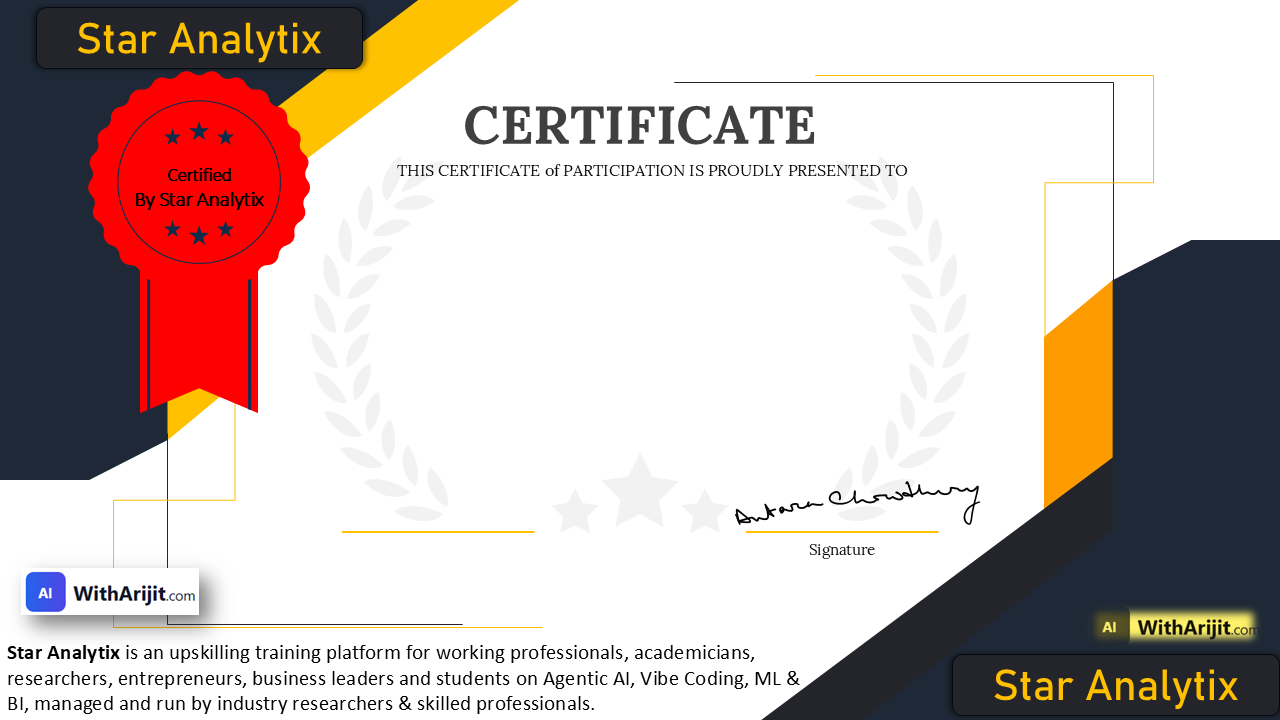

In [11]:
if TEMPLATE_IMG.exists():
    display(IPyImage(filename=str(TEMPLATE_IMG)))
else:
    print('Template not found at', TEMPLATE_IMG)

## Helper functions (same logic as script)
Do not change these unless you know what you're doing.

In [13]:
def sanitize_filename(s):
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = re.sub(r"[^\w\s\-_.]", "", s).strip()
    s = re.sub(r"[\s]+", "_", s)
    return s[:200] or "unknown"

def load_attendees(path):
    if not path.exists():
        raise FileNotFoundError(f"Input file not found: {path}")
    if path.suffix.lower() in [".xls", ".xlsx"]:
        df = pd.read_excel(path, engine="openpyxl")
    else:
        df = pd.read_csv(path)
    for c in ("Name", "Webinar Date", "Webinar Name"):
        if c not in df.columns:
            raise ValueError(f"Missing column '{c}' in input file")
    return df

def get_font(font_path, size):
    try:
        if font_path and Path(font_path).exists():
            return ImageFont.truetype(str(font_path), size)
    except Exception:
        pass
    return ImageFont.load_default()

# --- PATCH for Pillow 10+ (textsize removed) ---
def fit_text_font(draw, text, font_path, max_width, max_size, min_size=12):
    """
    Chooses the largest font size that fits within max_width.
    Compatible with Pillow >=10 (uses textbbox) and older versions.
    """
    for size in range(max_size, min_size - 1, -2):
        f = get_font(font_path, size)
        # textbbox returns (left, top, right, bottom)
        try:
            bbox = draw.textbbox((0, 0), text, font=f)
            w = bbox[2] - bbox[0]
        except AttributeError:
            # fallback for Pillow <10
            w, _ = draw.textsize(text, font=f)
        if w <= max_width:
            return f
    return get_font(font_path, min_size)

# Optional helper for width/height (also handles Pillow 10+)
def text_dimensions(draw, text, font):
    try:
        bbox = draw.textbbox((0, 0), text, font=font)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    except AttributeError:
        w, h = draw.textsize(text, font=font)
    return w, h

print("✅ Pillow 10+ compatibility patch loaded.")

def wrap_text_to_lines(draw, text, font, max_width):
    words = text.split()
    lines = []
    current = ""
    for w in words:
        test = (current + " " + w).strip()
        tw, th = draw.textsize(test, font=font)
        if tw <= max_width:
            current = test
        else:
            if current:
                lines.append(current)
            current = w
    if current:
        lines.append(current)
    return lines

def create_detail_lines(draw, name, webinar, date_str, font, max_width):
    pronoun = 'their'
    text = DETAIL_PARAGRAPH_TEMPLATE.format(NAME=name, WEBINAR=webinar, DATE=date_str, PRONOUN=pronoun)
    return wrap_text_to_lines(draw, text, font, max_width)

print('Helpers loaded')

✅ Pillow 10+ compatibility patch loaded.
Helpers loaded


## Generate certificates
Run the cell below to create certificates. Outputs will be saved in `certificates_output/`.

In [15]:
# ======= Patch: replace wrap_text_to_lines and create_detail_lines (Pillow 10+ safe) =======

def text_dimensions(draw, text, font):
    """Return width and height of text for Pillow 10+ and older versions."""
    try:
        bbox = draw.textbbox((0, 0), text, font=font)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
    except AttributeError:
        w, h = draw.textsize(text, font=font)
    return w, h

def wrap_text_to_lines(draw, text, font, max_width):
    """
    Wrap 'text' into a list of lines so each line's rendered width <= max_width.
    Uses text_dimensions() which supports Pillow >=10 and older.
    """
    words = text.split()
    if not words:
        return []

    lines = []
    current = words[0]

    for w in words[1:]:
        test = current + " " + w
        tw, th = text_dimensions(draw, test, font)
        if tw <= max_width:
            current = test
        else:
            lines.append(current)
            current = w
    lines.append(current)
    return lines

def create_detail_lines(draw, name, webinar, date_str, font, max_width):
    """Fill detail paragraph template and wrap to lines."""
    pronoun = 'their'
    text = DETAIL_PARAGRAPH_TEMPLATE.format(NAME=name, WEBINAR=webinar, DATE=date_str, PRONOUN=pronoun)
    return wrap_text_to_lines(draw, text, font, max_width)

print("Pillow-10+ compatible wrap/create_detail functions installed.")


Pillow-10+ compatible wrap/create_detail functions installed.


In [25]:
# === FONT SETUP CELL ===
# Run this before the Generate Certificates cell.

from pathlib import Path

# Base directory of your certificate project
#BASE_DIR = Path(r"C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script")

# Fonts folder (you already have this)
FONTS_DIR = BASE_DIR / "fonts"

# Define font paths for different text elements
FONT_PATH_NAME = FONTS_DIR / "PlayfairDisplay-Bold.ttf"     # Central attendee name
FONT_PATH_WEBINAR = FONTS_DIR / "Montserrat-Bold.ttf"       # Top-right webinar title
FONT_PATH_PARA = FONTS_DIR / "Lora-Regular.ttf"             # Paragraph body
FONT_PATH_DATE = FONTS_DIR / "OpenSans-Regular.ttf"         # Date

# Confirm all exist
print("Verifying fonts in folder:", FONTS_DIR, "\n")
for font_path in [FONT_PATH_NAME, FONT_PATH_WEBINAR, FONT_PATH_PARA, FONT_PATH_DATE]:
    print(f"{font_path.name:25} → {'✅ Found' if font_path.exists() else '❌ Missing'}")

# You can now safely use FONT_PATH_NAME, FONT_PATH_WEBINAR, FONT_PATH_PARA, FONT_PATH_DATE


Verifying fonts in folder: C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script\fonts 

PlayfairDisplay-Bold.ttf  → ✅ Found
Montserrat-Bold.ttf       → ✅ Found
Lora-Regular.ttf          → ✅ Found
OpenSans-Regular.ttf      → ✅ Found


## Adjust Sizes & Positions of Dynamic Parts in the Output
Adjust & Run the cell below before creating certificates

In [40]:
# Uses 4 custom fonts from your /fonts folder:
#   - PlayfairDisplay-Bold.ttf  → Attendee Name
#   - Montserrat-Bold.ttf       → Webinar Title
#   - Lora-Regular.ttf          → Paragraph text
#   - OpenSans-Regular.ttf      → Date text
# ---------------------------------------------------------------

from pathlib import Path
import zipfile
from PIL import Image, ImageDraw, ImageFont

# ----------------- VISUAL ADJUSTMENTS -----------------
# Webinar (top-right)
WEBINAR_FONT_SIZE = 28
WEBINAR_RIGHT_MARGIN = 120
WEBINAR_Y = 12

# Attendee name (center)
NAME_FORCE_SIZE = None      # set a number (e.g. 90) to force fixed size; None = auto-fit
NAME_MAX_SIZE = 60
NAME_MIN_SIZE = 28
NAME_X_ADJUST = 60          # move right (+) or left (-)
NAME_Y = 250
NAME_MAX_WIDTH_ADJUST = 220 # lower = allows wider text (larger name font)

# Paragraph (body text)
PARA_FONT_SIZE = 16
PARA_WRAP_WIDTH = 600
PARA_LINE_SPACING = 4
PARA_TOP_OFFSET = 45
PARA_X_ADJUST = 35

# Date (left orange area)
DATE_FONT_SIZE = 20
DATE_X = 350
DATE_Y = 480
# -------------------------------------------------------

## Generate The Certificates
Final Certificate Generation Code Block is here below

In [42]:
# === FINAL GENERATE CERTIFICATES CELL (NO UNDERLINE VERSION) ===

# Paths (already defined in previous cells)
# BASE_DIR, TEMPLATE_IMG, OUTPUT_FOLDER, INPUT_FILE, ZIP_NAME, etc.
# FONT_PATH_NAME, FONT_PATH_WEBINAR, FONT_PATH_PARA, FONT_PATH_DATE

def text_dimensions(draw, text, font):
    """Return (width, height) for given text and font; works for all Pillow versions."""
    try:
        bbox = draw.textbbox((0, 0), text, font=font)
        return bbox[2] - bbox[0], bbox[3] - bbox[1]
    except AttributeError:
        return draw.textsize(text, font=font)

def wrap_text(draw, text, font, max_width):
    """Simple text wrapper for paragraph."""
    words, lines, current = text.split(), [], ""
    for w in words:
        test = (current + " " + w).strip()
        tw, _ = text_dimensions(draw, test, font)
        if tw <= max_width:
            current = test
        else:
            if current:
                lines.append(current)
            current = w
    if current:
        lines.append(current)
    return lines

# Ensure output folder exists
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

# Load attendees list
df = load_attendees(INPUT_FILE)
base = Image.open(TEMPLATE_IMG).convert("RGBA")
W, H = base.size
print(f"Template size: {W}x{H}")

created_files = []

# Generate certificates
for idx, row in df.iterrows():
    name = str(row["Name"]).strip()
    webinar = str(row["Webinar Name"]).strip()
    date = str(row["Webinar Date"]).strip()

    img = base.copy()
    draw = ImageDraw.Draw(img)

    # === 1. Webinar Title (top-right) ===
    webinar_font = ImageFont.truetype(str(FONT_PATH_WEBINAR), WEBINAR_FONT_SIZE)
    wb_w, wb_h = text_dimensions(draw, webinar, webinar_font)
    draw.text((W - wb_w - WEBINAR_RIGHT_MARGIN, WEBINAR_Y),
              webinar, font=webinar_font, fill=(30, 30, 30))

    # === 2. Participant Name (center, auto-fit or forced) ===
    horiz_max_width = W - NAME_MAX_WIDTH_ADJUST
    if NAME_FORCE_SIZE:
        chosen_font = ImageFont.truetype(str(FONT_PATH_NAME), NAME_FORCE_SIZE)
    else:
        chosen_font = None
        for size in range(NAME_MAX_SIZE, NAME_MIN_SIZE - 1, -2):
            f = ImageFont.truetype(str(FONT_PATH_NAME), size)
            nw, nh = text_dimensions(draw, name, f)
            if nw <= horiz_max_width:
                chosen_font = f
                break
        if not chosen_font:
            chosen_font = ImageFont.truetype(str(FONT_PATH_NAME), NAME_MIN_SIZE)

    name_w, name_h = text_dimensions(draw, name, chosen_font)
    name_x = ((W - name_w) // 2) + NAME_X_ADJUST
    name_y = NAME_Y
    draw.text((name_x, name_y), name, font=chosen_font, fill=(212, 160, 23))

    # === 3. Paragraph Text ===
    paragraph_font = ImageFont.truetype(str(FONT_PATH_PARA), PARA_FONT_SIZE)
    paragraph_text = DETAIL_PARAGRAPH_TEMPLATE.format(NAME=name, WEBINAR=webinar, DATE=date, PRONOUN="their")
    lines = wrap_text(draw, paragraph_text, paragraph_font, PARA_WRAP_WIDTH)

    start_y = name_y + name_h + PARA_TOP_OFFSET
    for ln in lines:
        lw, lh = text_dimensions(draw, ln, paragraph_font)
        draw.text(((W - lw)//2 + PARA_X_ADJUST, start_y),
                  ln, font=paragraph_font, fill=(60, 60, 60))
        start_y += lh + PARA_LINE_SPACING

    # === 4. Date ===
    date_font = ImageFont.truetype(str(FONT_PATH_DATE), DATE_FONT_SIZE)
    draw.text((DATE_X, DATE_Y), f"Date : {date}", font=date_font, fill=(60, 60, 60))

    # === 5. Signature (optional) ===
    sig_path = BASE_DIR / "signature.png"
    if sig_path.exists():
        try:
            sig = Image.open(sig_path).convert("RGBA")
            max_sig_w = int(W * 0.18)
            if sig.width > max_sig_w:
                sig = sig.resize((max_sig_w, int(sig.height * max_sig_w / sig.width)), Image.Resampling.LANCZOS)
            margin = int(W * 0.05)
            sx, sy = W - sig.width - margin, H - sig.height - margin
            img.paste(sig, (sx, sy), sig)
        except Exception as e:
            print("Signature paste failed:", e)

    # === 6. Save File ===
    out_fname = f"{sanitize_filename(webinar)}_{sanitize_filename(date)}_{sanitize_filename(name)}.{OUTPUT_FORMAT.lower()}"
    out_path = OUTPUT_FOLDER / out_fname
    if OUTPUT_FORMAT.upper() == "PNG":
        img.convert("RGB").save(out_path, "PNG")
    else:
        img.convert("RGB").save(out_path, "JPEG", quality=JPG_QUALITY)

    created_files.append(out_path)
    print(f"[{idx+1}/{len(df)}] Saved: {out_path.name}")

# === 7. Zip all files ===
zip_path = OUTPUT_FOLDER / ZIP_NAME
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
    for f in created_files:
        zf.write(f, arcname=f.name)

print(f"\n✅ Done: {len(created_files)} certificates created.")
print("Output folder:", OUTPUT_FOLDER)
print("ZIP file:", zip_path)


Template size: 1280x720
[1/4] Saved: Sample_Test_Webinar_07Sep2025_Neeraj_Kumar.png
[2/4] Saved: Sample_Test_Webinar_07Sep2025_Verghese_M_U.png
[3/4] Saved: Sample_Test_Webinar_07Sep2025_Ameya_Shivaji_Mohite.png
[4/4] Saved: Sample_Test_Webinar_07Sep2025_SHIVAKUMAR_RAMU.png

✅ Done: 4 certificates created.
Output folder: C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script\certificates_output
ZIP file: C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script\certificates_output\certificates.zip


## Coordinate Finder (visual helper)
Run the cell below to open a simple coordinate finder: it will display the template and print x,y coordinates when you click on the image. Useful to fine-tune `NAME_Y`, `DETAIL_TOP_Y`, etc.

Click on the displayed image inside the notebook; the output area will show the coordinates.

In [38]:
# === COORDINATE FINDER (Matplotlib GUI version – reliable, no JS required) ===
# Works in JupyterLab, VS Code, or any Python IDE that supports pop-up windows.
# Opens your certificate template in a separate window.
# Click anywhere to get (x, y). Close the window to end.
# --------------------------------------------------------

import matplotlib
matplotlib.use("TkAgg")  # Forces GUI mode for reliable click capture
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Load your certificate template
img_path = Path(TEMPLATE_IMG)

img = Image.open(img_path).convert("RGB")
W, H = img.size
print(f"Loaded template: {img_path}  (size: {W}x{H})")
print("A new window will open. Click anywhere to record coordinates. Close window when done.\n")

LAST_CLICK_COORDS = []
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)
ax.axis("off")
ax.set_title("Click to record coordinates (close window when finished)")

def onclick(event):
    if event.xdata and event.ydata:
        x, y = int(event.xdata), int(event.ydata)
        LAST_CLICK_COORDS.append((x, y))
        print(f"Clicked: X={x}, Y={y}")
        ax.plot(x, y, 'r+', markersize=10)
        ax.annotate(f"({x},{y})", (x+10, y-10), color='red', fontsize=8, backgroundcolor='white')
        fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

print("\nLAST_CLICK_COORDS (most recent first):", list(reversed(LAST_CLICK_COORDS)))
print("Tip: Use these coordinates in your Generate cell (NAME_Y, DATE_X, DATE_Y, etc.)")


Loaded template: C:\Users\ariji\OneDrive - Star Analutics\Certificates\Webinar Certificates\Certificate Generator Python Script\7045842764_090625.png  (size: 1280x720)
A new window will open. Click anywhere to record coordinates. Close window when done.

Clicked: X=345, Y=297
Clicked: X=745, Y=313

LAST_CLICK_COORDS (most recent first): [(745, 313), (345, 297)]
Tip: Use these coordinates in your Generate cell (NAME_Y, DATE_X, DATE_Y, etc.)


----
When you're finished, you can download the generated ZIP from the `certificates_output` folder.